This a method to estimate the real probability of default. As proposed by Yeh, I. C., & Lien, C. H. (2009):

"*To estimate the real probability of default, the novel
approach, called Sorting Smoothing Method (SSM), was
proposed in this study. Firstly, according to the predictive
probability, order the validation data from the minimum to
the maximum. Secondly, use the SSM to estimate the real
probability of default as follows:*"

$$ P_{i} = \frac{Y_{i-n}+.......+Y_{i}+......+Y_{i+n}}{2n+1} $$
Where $n$ is the number of neighbors to smoot.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# set plot style if no arguments provided
jtplot.style()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

In [3]:
df = pd.read_excel("default of credit card clients.xls", header=1)
# put ID as DataFrame INDEX
df.set_index('ID', inplace=True)

drop = ['PAY_AMT5', 'BILL_AMT5','BILL_AMT4','PAY_3','PAY_4',
 'EDUCATION','PAY_6','SEX','MARRIAGE','PAY_5']
# train test split
X, y = df.drop(['default payment next month']+drop, axis=1).values, df['default payment next month'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
model = BalancedRandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=True,
                                       min_samples_leaf=10, max_samples=0.7,
                                       min_samples_split=20, max_features=0.7,
                                       random_state=42, n_jobs=4, sampling_strategy=0.6)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=15, max_features=0.7, max_samples=0.7,
                               min_samples_leaf=10, min_samples_split=20,
                               n_estimators=200, n_jobs=4, random_state=42,
                               sampling_strategy=0.6)

In [16]:
y_proba = model.predict_proba(X_test)[:, 1]
df_smoothing = pd.DataFrame()
df_smoothing['y_proba'] = y_proba
df_smoothing['default'] = y_test
df_smoothing.sort_values('y_proba', inplace=True)

In [33]:
n = 10
smoothing = []
for i in list(range(n, y_test.shape[0]-n+1)):
    real_prob = df_smoothing.iloc[i-n:i+n+1, :]['default'].mean()
    smoothing.append([df_smoothing['y_proba'].iloc[i], real_prob])
    
smoothing = pd.DataFrame(smoothing, columns=['model_proba', 'real_proba'])

<AxesSubplot:xlabel='model_proba', ylabel='real_proba'>

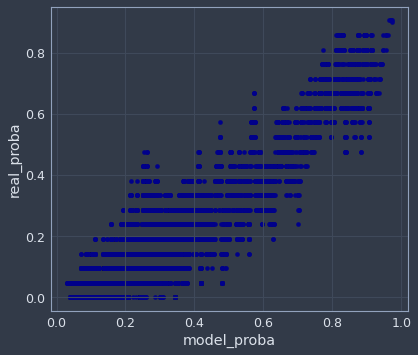

In [38]:
smoothing.plot.scatter(x='model_proba', y='real_proba', c='DarkBlue')

In [43]:
from sklearn.linear_model import LinearRegression
X = smoothing['model_proba'].values
y = smoothing['real_proba'].values
reg = LinearRegression().fit(X.reshape(-1, 1), y)

In [54]:
m = reg.coef_
intercept = reg.intercept_
r_2 = reg.score(X.reshape(-1, 1), y)

print(f"y = {round(intercept, 4)} + {round(m[0], 4)}x \n r_2={round(r_2, 4)}")

y = -0.0626 + 0.8301x 
 r_2=0.8173
